In [1]:
import numpy as np
import pandas as pd
import os
import spacy
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SVMSMOTE, ADASYN
from imblearn.combine import SMOTETomek
from lightgbm import LGBMClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
#from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, confusion_matrix, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
# making our dependent variable

In [2]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("drugsComTrain_raw.tsv",sep='\t')
df1.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
df2 = pd.read_csv("drugsComTest_raw.tsv",sep='\t')
df2.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [4]:
df = pd.concat([df1, df2])
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

In [6]:
df.head()

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            215063 non-null  int64  
 1   drug name     215063 non-null  object 
 2   condition     213869 non-null  object 
 3   review        215063 non-null  object 
 4   rating        215063 non-null  float64
 5   date          215063 non-null  object 
 6   useful count  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 13.1+ MB


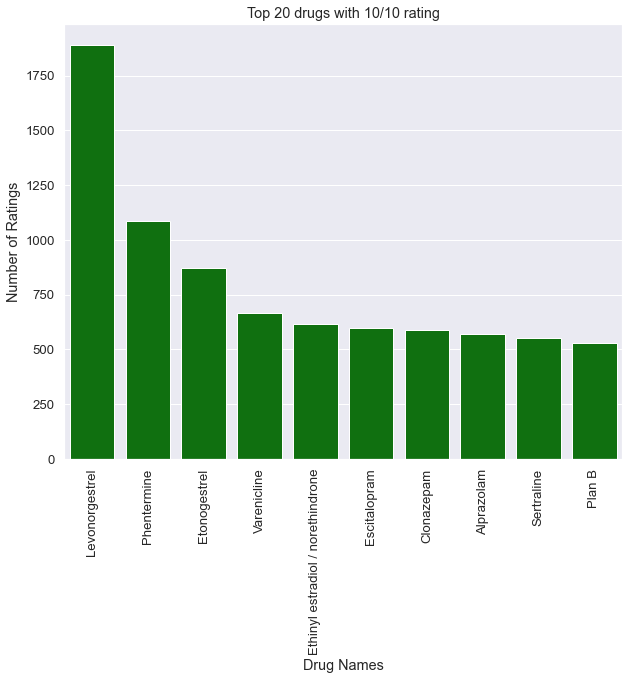

In [8]:
import seaborn as sns
#!pip install matplotlib
import matplotlib.pyplot as plt

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [10, 8]

rating = dict(df.loc[df.rating == 10, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:10], y = drug_rating[0:10],color='green')

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

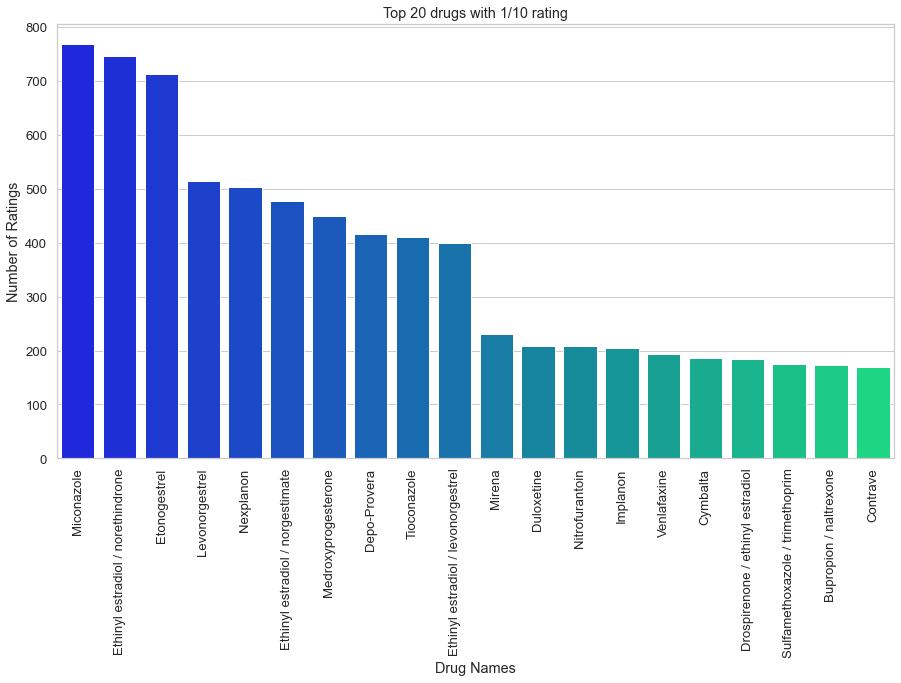

In [9]:
# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

C:\Users\renaik\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\renaik\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Rating')

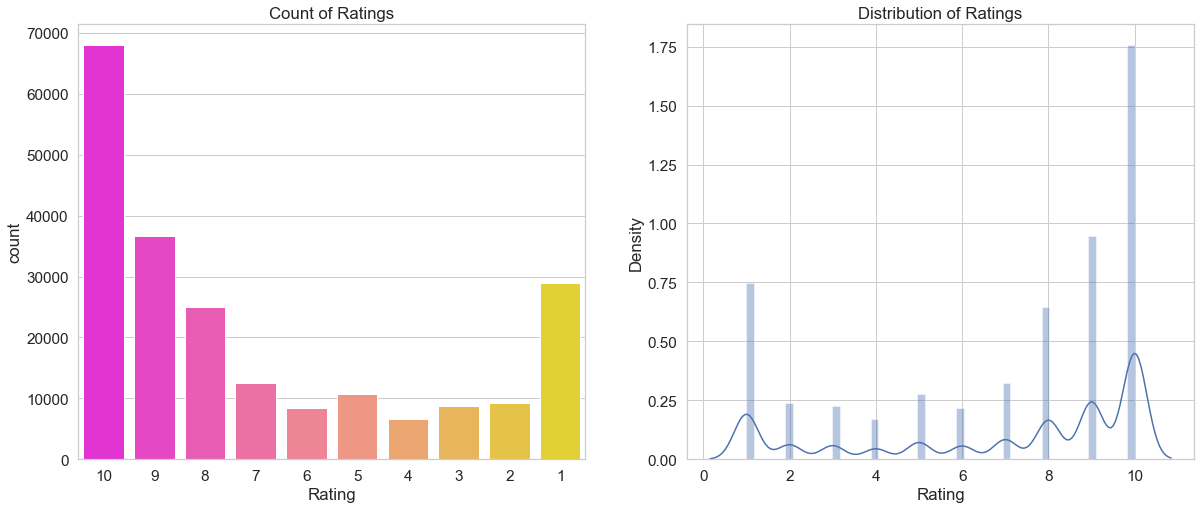

In [10]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)

sns_1 = sns.countplot(df['rating'], palette = 'spring', order = list(range(10, 0, -1)), ax = ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

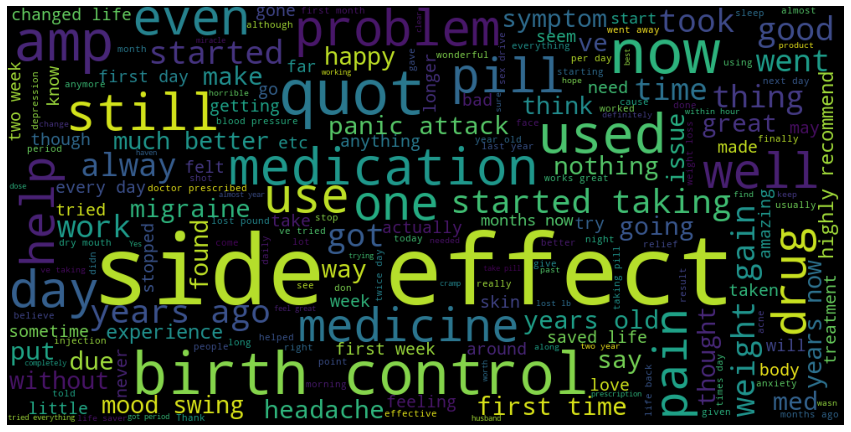

In [11]:
#!pip install wordcloud
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

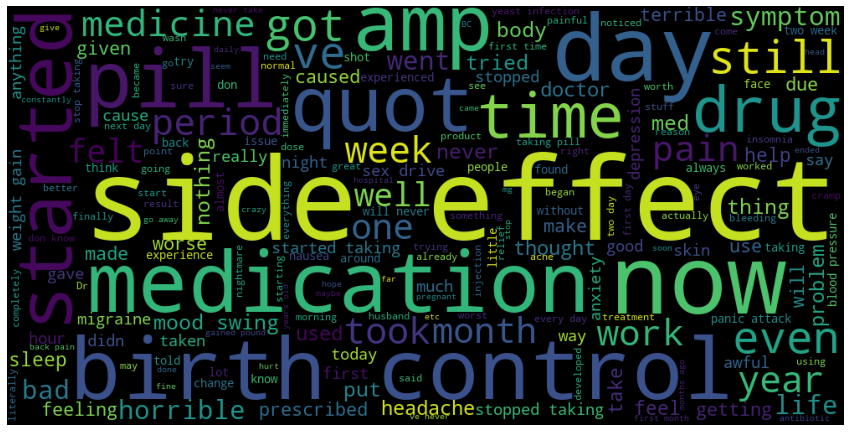

In [12]:
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 1
df_rate_ten = df.loc[df.rating == 1, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

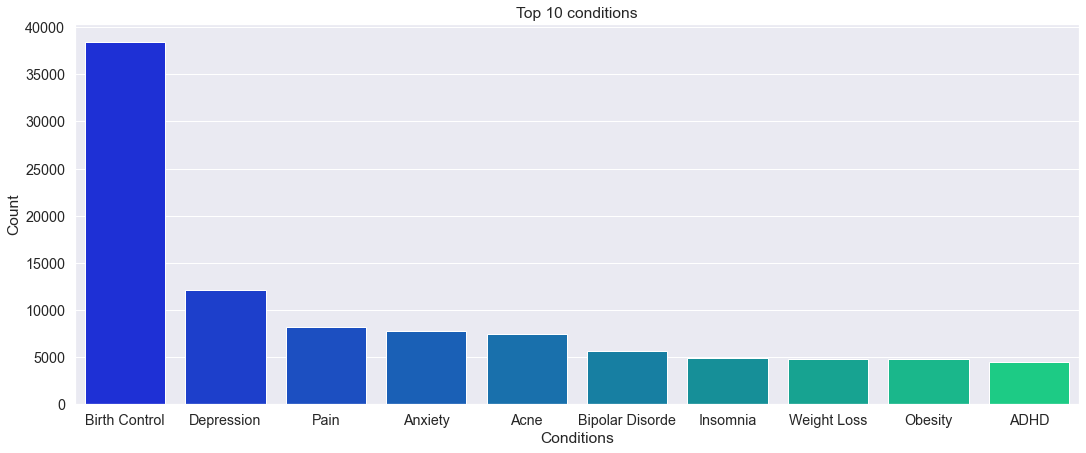

In [13]:
# This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            215063 non-null  int64  
 1   drug name     215063 non-null  object 
 2   condition     213869 non-null  object 
 3   review        215063 non-null  object 
 4   rating        215063 non-null  float64
 5   date          215063 non-null  object 
 6   useful count  215063 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 17.2+ MB


In [15]:
df2 = df[df['useful count'] > 10]  

In [16]:
df_condition = df2.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drug name
706,64</span> users found this comment helpful.,1
707,92</span> users found this comment helpful.,1
708,Gastritis/Duodenitis,1
709,Esophageal Variceal Hemorrhage Prophylaxis,1
710,98</span> users found this comment helpful.,1
711,Severe Mood Dysregulation,1
712,Short Stature,1
713,Short Stature for Age,1
714,Meningitis,1
715,"Skin Disinfection, Preoperative",1


In [17]:
df_condition_1 = df_condition[df_condition['drug name'] == 1].reset_index()

all_list = set(df.index)

# deleting them
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [18]:
df.shape

(160684, 7)

In [19]:
# removing the conditions with <span> in it.

all_list = set(df.index)
span_list = []
for i,j in enumerate(df['condition']):
    if "</span>" in str(j):
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [20]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [21]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [22]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS


In [23]:
%time df['review_clean'] = df['review'].apply(review_to_words)
df.head()

Wall time: 1min 31s


,ID,drug name,condition,review,rating,date,useful count,review_clean
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...


In [24]:
bow_vector = CountVectorizer(analyzer = 'word',stop_words = stop_words, ngram_range=(1,3))
#  tf-idf vector
tfidf_vector = TfidfVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = stop_words, 
                             min_df = 2, 
                             ngram_range=(1,3),
                             max_features = 20000)

In [25]:
print(bow_vector)

CountVectorizer(ngram_range=(1, 3),
                stop_words={"'d", "'ll", "'m", "'re", "'s", "'ve", 'a', 'about',
                            'above', 'across', 'after', 'afterwards', 'again',
                            'against', 'all', 'almost', 'alone', 'along',
                            'already', 'also', 'although', 'always', 'am',
                            'among', 'amongst', 'amount', 'an', 'and',
                            'another', 'any', ...})


In [26]:
#Verification using Machine Learning Models
from sklearn.model_selection import train_test_split


In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

df.loc[(df['rating'] >= 5), 'Review_Sentiment'] = 1
df.loc[(df['rating'] < 5), 'Review_Sentiment'] = 0

df['Review_Sentiment'].value_counts()



1.0    120085
0.0     39723
Name: Review_Sentiment, dtype: int64

# Random Over Sampler with Count Vector

In [83]:
# split into train and test
df_train, df_test = train_test_split(df, train_size=0.75, random_state=100)
df_train.shape, df_test.shape

((119856, 9), (39952, 9))

In [84]:
#tfidfcv= TfidfVectorizer(max_features=30000,ngram_range=(1,3))
#pipeline = Pipeline([('vect',tfidfcv)])

cv = CountVectorizer(max_features = 40000, ngram_range = (1,3))
pipeline = Pipeline([('vect',cv)])

In [85]:
X_train_features= pipeline.fit_transform(df_train['review_clean'])
X_test = pipeline.fit_transform(df_test['review_clean'])

In [86]:
y_train=df_train['Review_Sentiment']
y_test=df_test['Review_Sentiment']

In [87]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 89951
Before OverSampling, counts of label '0': 29905 



In [88]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_features, y_train)

In [89]:
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_res == 0)))

After OverSampling, counts of label '1': 89951
After OverSampling, counts of label '0': 89951 



In [90]:
# Logistic Regression

logreg = LogisticRegression(random_state=0)
logreg.fit(X_res, y_res)
y_pred2 = logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred2)
print("Log Reg: ", logreg_accuracy )

Log Reg:  0.5101621946335603


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [91]:
#AUC
from sklearn.metrics import roc_curve, auc
y_score = logreg.fit(X_res, y_res).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [94]:
#Classification Report
target_names = ["Negative", "Positive"]
print(classification_report(y_test, y_pred2,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.25      0.51      0.34      9818
    Positive       0.76      0.51      0.61     30134

    accuracy                           0.51     39952
   macro avg       0.51      0.51      0.48     39952
weighted avg       0.64      0.51      0.54     39952



In [95]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred2, y_true=y_test)
cm2

array([[ 5050,  4768],
       [14802, 15332]], dtype=int64)

In [96]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.5158521464855633


In [97]:
Sgb= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=10, tol=None)
Sgb.fit(X_res, y_res)
y_pred7 = Sgb.predict(X_test)
sgd_accuracy = accuracy_score(y_test, y_pred7)
print("SGD: ", sgd_accuracy)

SGD:  0.3623598317981578


In [100]:
#AUC
from sklearn.metrics import roc_curve, auc
y_score = Sgb.fit(X_res, y_res).decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_score)

In [101]:
#Classification Report
target_names = ["Negative", "Positive"]
print(classification_report(y_test, y_pred7,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.25      0.81      0.38      9818
    Positive       0.78      0.22      0.34     30134

    accuracy                           0.36     39952
   macro avg       0.51      0.51      0.36     39952
weighted avg       0.65      0.36      0.35     39952



In [102]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred2, y_true=y_test)
cm2

array([[ 5050,  4768],
       [14802, 15332]], dtype=int64)

In [103]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.5264198740296331


In [104]:
mnb = MultinomialNB()
mnb.fit(X_res, y_res)
y_pred3 = mnb.predict(X_test)

mnb_accuracy = accuracy_score(y_test, y_pred3)
print("MNB Reg: ", mnb_accuracy )

MNB Reg:  0.7447687224669604


In [106]:
#AUC
from sklearn.metrics import roc_curve, auc
y_score3 = mnb.fit(X_res, y_res).predict_proba(X_test)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_score3[:,1])
print('AUC: {}'.format(auc(fpr3, tpr3)))

AUC: 0.6200449562538635


In [107]:
#Classification Report
target_names = ["Negative", "Positive"]
print(classification_report(y_test, y_pred3,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.44      0.15      0.23      9818
    Positive       0.77      0.94      0.85     30134

    accuracy                           0.74     39952
   macro avg       0.61      0.54      0.54     39952
weighted avg       0.69      0.74      0.69     39952



In [108]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred3, y_true=y_test)
cm2

array([[ 1483,  8335],
       [ 1862, 28272]], dtype=int64)

In [109]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.5264198740296331


In [115]:
l_gbm= LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
l_gbm.fit(X_res.astype(np.float32), y_res.astype(np.float32))
y_pred3 = l_gbm.predict(X_test.astype(np.float32))

l_gbm_accuracy = accuracy_score(y_test, y_pred3)
print("LightGBM: ", l_gbm_accuracy )

C:\Users\renaik\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LightGBM:  0.6490038045654786


In [117]:
#Classification Report
target_names = ["Negative", "Positive"]
print(classification_report(y_test, y_pred3,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.29      0.31      0.30      9818
    Positive       0.77      0.76      0.77     30134

    accuracy                           0.65     39952
   macro avg       0.53      0.53      0.53     39952
weighted avg       0.65      0.65      0.65     39952



In [118]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred3, y_true=y_test)
cm2

array([[ 3008,  6810],
       [ 7213, 22921]], dtype=int64)

In [119]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.5264198740296331


In [120]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=100, oob_score=True,class_weight="balanced_subsample")
rf.fit(X_res, y_res)
y_pred3 = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred3)
print("Random Forest Reg: ", rf_accuracy )

Random Forest Reg:  0.2534541449739688


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


# SMOTE with Count Vector

In [121]:
# split into train and test
df_train, df_test = train_test_split(df, train_size=0.75, random_state=100)
df_train.shape, df_test.shape

((119856, 9), (39952, 9))

In [122]:
cv = CountVectorizer(max_features = 40000, ngram_range = (1,3))
pipeline = Pipeline([('vect',cv)])

In [123]:
X_train_features= pipeline.fit_transform(df_train['review_clean'])
X_test = pipeline.fit_transform(df_test['review_clean'])

In [124]:
y_train=df_train['Review_Sentiment']
y_test=df_test['Review_Sentiment']

In [125]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 89951
Before OverSampling, counts of label '0': 29905 



In [126]:
smote = SMOTE(random_state=142)
X_res, y_res = smote.fit_resample(X_train_features, y_train)

In [127]:
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_res == 0)))

After OverSampling, counts of label '1': 89951
After OverSampling, counts of label '0': 89951 



In [128]:
logreg = LogisticRegression(random_state=0)
logreg.fit(X_res, y_res)
y_pred2 = logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred2)
print("Log Reg: ", logreg_accuracy )

Log Reg:  0.6166399679615538


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [129]:
Sgb= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=10, tol=None)
Sgb.fit(X_res, y_res)
y_pred7 = Sgb.predict(X_test)
sgd_accuracy = accuracy_score(y_test, y_pred7)
print("SGD: ", sgd_accuracy)

SGD:  0.322336804164998


In [130]:
mnb = MultinomialNB()
mnb.fit(X_res, y_res)
y_pred3 = mnb.predict(X_test)

mnb_accuracy = accuracy_score(y_test, y_pred3)
print("MNB Reg: ", mnb_accuracy )

MNB Reg:  0.7537545054064878


In [131]:
l_gbm= LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
l_gbm.fit(X_res.astype(np.float32), y_res.astype(np.float32))
y_pred3 = l_gbm.predict(X_test.astype(np.float32))

l_gbm_accuracy = accuracy_score(y_test, y_pred3)
print("LightGBM: ", l_gbm_accuracy )

C:\Users\renaik\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LightGBM:  0.48873648378053663


In [132]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=100, oob_score=True,class_weight="balanced_subsample")
rf.fit(X_res, y_res)
y_pred3 = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred3)
print("Random Forest Reg: ", rf_accuracy )

Random Forest Reg:  0.24712154585502602


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


# ADASYN With Count Vector

In [133]:
# split into train and test
df_train, df_test = train_test_split(df, train_size=0.75, random_state=100)
df_train.shape, df_test.shape

((119856, 9), (39952, 9))

In [134]:
cv = CountVectorizer(max_features = 40000, ngram_range = (1,3))
pipeline = Pipeline([('vect',cv)])

In [135]:
X_train_features= pipeline.fit_transform(df_train['review_clean'])
X_test = pipeline.fit_transform(df_test['review_clean'])

In [136]:
y_train=df_train['Review_Sentiment']
y_test=df_test['Review_Sentiment']

In [137]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 89951
Before OverSampling, counts of label '0': 29905 



In [138]:
ada = ADASYN(random_state=142)
X_res, y_res = ada.fit_resample(X_train_features, y_train)

In [139]:
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_res == 0)))

After OverSampling, counts of label '1': 89951
After OverSampling, counts of label '0': 90589 



In [140]:
logreg = LogisticRegression(random_state=0)
logreg.fit(X_res, y_res)
y_pred2 = logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred2)
print("Log Reg: ", logreg_accuracy )

Log Reg:  0.6209701641970364


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [141]:
Sgb= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=10, tol=None)
Sgb.fit(X_res, y_res)
y_pred7 = Sgb.predict(X_test)
sgd_accuracy = accuracy_score(y_test, y_pred7)
print("SGD: ", sgd_accuracy)

SGD:  0.3083450140168202


In [142]:
mnb = MultinomialNB()
mnb.fit(X_res, y_res)
y_pred3 = mnb.predict(X_test)

mnb_accuracy = accuracy_score(y_test, y_pred3)
print("MNB Reg: ", mnb_accuracy )

MNB Reg:  0.7529535442531037


In [143]:
l_gbm= LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
l_gbm.fit(X_res.astype(np.float32), y_res.astype(np.float32))
y_pred3 = l_gbm.predict(X_test.astype(np.float32))

l_gbm_accuracy = accuracy_score(y_test, y_pred3)
print("LightGBM: ", l_gbm_accuracy )

C:\Users\renaik\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LightGBM:  0.4894373247897477


In [144]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=100, oob_score=True,class_weight="balanced_subsample")
rf.fit(X_res, y_res)
y_pred3 = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred3)
print("Random Forest Reg: ", rf_accuracy )

Random Forest Reg:  0.246620945134161


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


# SMOTETomek with Count Vector

In [145]:
# split into train and test
df_train, df_test = train_test_split(df, train_size=0.75, random_state=100)
df_train.shape, df_test.shape

((119856, 9), (39952, 9))

In [146]:
cv = CountVectorizer(max_features = 40000, ngram_range = (1,3))
pipeline = Pipeline([('vect',cv)])

In [147]:
X_train_features= pipeline.fit_transform(df_train['review_clean'])
X_test = pipeline.fit_transform(df_test['review_clean'])

In [148]:
y_train=df_train['Review_Sentiment']
y_test=df_test['Review_Sentiment']

In [149]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 89951
Before OverSampling, counts of label '0': 29905 



In [151]:
smotetm = SMOTETomek(random_state=142)
X_res, y_res = smotetm.fit_resample(X_train_features, y_train)

In [152]:
print("After OverSampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After OverSampling, counts of label '0': {} \n".format(sum(y_res == 0)))

After OverSampling, counts of label '1': 89931
After OverSampling, counts of label '0': 89931 



In [153]:
logreg = LogisticRegression(random_state=0)
logreg.fit(X_res, y_res)
y_pred2 = logreg.predict(X_test)

logreg_accuracy = accuracy_score(y_test, y_pred2)
print("Log Reg: ", logreg_accuracy )

Log Reg:  0.6169903884661594


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [154]:
Sgb= SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=0, max_iter=10, tol=None)
Sgb.fit(X_res, y_res)
y_pred7 = Sgb.predict(X_test)
sgd_accuracy = accuracy_score(y_test, y_pred7)
print("SGD: ", sgd_accuracy)

SGD:  0.32276231477773326


In [155]:
mnb = MultinomialNB()
mnb.fit(X_res, y_res)
y_pred3 = mnb.predict(X_test)

mnb_accuracy = accuracy_score(y_test, y_pred3)
print("MNB Reg: ", mnb_accuracy )

MNB Reg:  0.7537545054064878


In [156]:
l_gbm= LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
l_gbm.fit(X_res.astype(np.float32), y_res.astype(np.float32))
y_pred3 = l_gbm.predict(X_test.astype(np.float32))

l_gbm_accuracy = accuracy_score(y_test, y_pred3)
print("LightGBM: ", l_gbm_accuracy )

C:\Users\renaik\Anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


LightGBM:  0.48375550660792954


In [157]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=100, oob_score=True,class_weight="balanced_subsample")
rf.fit(X_res, y_res)
y_pred3 = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred3)
print("Random Forest Reg: ", rf_accuracy )

Random Forest Reg:  0.24679615538646377


C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\renaik\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
